In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam

class CBAMLayer(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel = input_shape[-1]
        self.shared_dense_one = tf.keras.layers.Dense(self.channel // self.reduction_ratio,
                                                      activation='relu')
        self.shared_dense_two = tf.keras.layers.Dense(self.channel)

        self.conv_spatial = tf.keras.layers.Conv2D(filters=1,
                                                   kernel_size=7,
                                                   padding='same',
                                                   activation='sigmoid')

    def call(self, inputs):
        # Channel Attention
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        scale = tf.nn.sigmoid(avg_out + max_out)
        x = inputs * scale

        # Spatial Attention
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        scale = self.conv_spatial(concat)
        x = x * scale
        return x

Model_Input=Input(shape=(None, None,3))
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(None, None,3))

conv_base = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)

conv_base.summary()

x = conv_base(Model_Input)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 7,635,264 (29.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
p1 = CBAMLayer()(x)

a1 = Conv2D(256, 3, padding='same', activation='relu')(p1)
a2 = Conv2D(256, 3, padding='same', activation='relu')(a1)
a3 = Conv2D(128, 3, padding='same', activation='relu')(a2)
a4 = Conv2D(128, 3, padding='same', activation='relu')(a3)

skip_early = add([a1, a2])  
skip_late = add([a3, a4])   

early_reduced = Conv2D(64, 1, activation='relu')(skip_early)  
late_reduced = Conv2D(64, 1, activation='relu')(skip_late)   

a5 = concatenate([early_reduced, late_reduced])  
a6 = Conv2D(64, 3, padding='same', activation='relu')(a5)   

b1 = Conv2D(256, 5, padding='same', activation='relu')(p1)
b2 = Conv2D(256, 5, padding='same', activation='relu')(b1)
b3 = Conv2D(128, 3, padding='same', activation='relu')(b2)
b4 = Conv2D(64, 3, padding='same', activation='relu')(b3)

merged_output = concatenate([a6, b4])  
k = Conv2D(64, 1, activation='relu')(merged_output)
d1 = CBAMLayer()(k)
e1 = Conv2D(1, 1)(d1)

model = Model(inputs=Model_Input, outputs=e1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, None,      │  7,635,264 │ input_layer[0][0] │
│ (Functional)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_layer          │ (None, None,      │     66,211 │ functional[0][0]  │
│ (CBAMLayer)         │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │  1,179,904 │ cbam_layer[0][0]  │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │    590,080 │ conv2d_1[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │    295,040 │ conv2d_2[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    147,584 │ conv2d_3[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ conv2d_1[0][0],   │
│                     │ None, 256)        │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ conv2d_3[0][0],   │
│                     │ None, 128)        │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │  3,277,056 │ cbam_layer[0][0]  │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     16,448 │ add[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │      8,256 │ add_1[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, None,      │  1,638,656 │ conv2d_8[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ None, 128)        │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, None,      │    295,040 │ conv2d_9[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │     73,792 │ concatenate[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, None,      │     73,792 │ conv2d_10[0][0] 

 Total params: 15,306,639 (58.39 MB)

 Trainable params: 15,306,639 (58.39 MB)

 Non-trainable params: 0 (0.00 B)

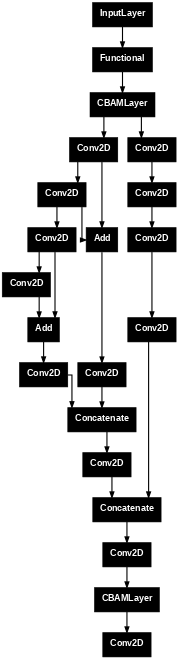

In [ ]:
from keras.utils import plot_model
plot_model(model,dpi=40)

In [ ]:
def crowd_counting_loss(y_true, y_pred, alpha, gamma):
    
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    abs_error = tf.abs(y_true - y_pred)
    focal_weight = tf.pow(abs_error + 1e-8, gamma)  
    focal_loss = tf.reduce_mean(focal_weight * tf.square(y_true - y_pred))

    total_loss = (1 - alpha) * mse_loss + alpha * focal_loss

    return total_loss

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=lambda y_true, y_pred: crowd_counting_loss(y_true, y_pred, alpha=0.7, gamma=4.0),
    metrics=[MeanAbsoluteError()]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-8
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=100,
    validation_steps=10,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 956ms/step - loss: 4.6664e-04 - mean_absolute_error: 0.0187 - val_loss: 1.6172e-04 - val_mean_absolute_error: 0.0073 - learning_rate: 1.0000e-05
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 1.1981e-04 - mean_absolute_error: 0.0073 - val_loss: 1.1749e-04 - val_mean_absolute_error: 0.0070 - learning_rate: 1.0000e-05
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 917ms/step - loss: 1.1262e-04 - mean_absolute_error: 0.0065 - val_loss: 1.3962e-04 - val_mean_absolute_error: 0.0066 - learning_rate: 1.0000e-05
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - loss: 1.0730e-04 - mean_absolute_error: 0.0060
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 1.0723e-04 - mean_absolute_error: 0.0060 - val_loss: 6.5596e-05 - val_mean_absolute_error: 0.0055 - learning_rate: 1.0000e-05
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 1.0258e-04 - 

In [ ]:

model.save('new_model_11.keras')

from google.colab import files
files.download('new_model_11.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: crowd_counting_loss(y_true, y_pred, alpha=0.6, gamma=4.0),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>